In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part1.ipynb")

# Final Project: COVID-19 Dataset

## Group Members: 

## Yucheng Jin, 3037442109, yuchengjin@berkeley.edu

## Tinna Liu, 3035729670, tinnaliu@berkeley.edu

## Jiayin Guo, 3035418572, guojiayin@berkeley.edu

## Exploring COVID-19 Data through Modeling
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own group**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Question 0: Basic Time Series Modeling

We will introduce a few basic modeling techniques using temporally correlated data that you are free to adapt or improve throughout your modeling process if you wish. Answer these questions in their respective cells below.

### Question 0a
Suppose $\tilde{x} = [1, x_{t}]$ represents the input to a machine learning function $f_\theta: \mathbb{R}^{2} \rightarrow \mathbb{R}$, and we wish to predict $x_{t + 1}$ such that $f_\theta(\tilde{x}) \approx x_{t+1}$. You may assume that $t = 0$ corresponds to the start of time. 

<!-- BEGIN QUESTION -->

i) Is this an example of supervised or unsupervised learning?
<!--
BEGIN QUESTION
name: q0ai
points: 2
manual: True
-->

_This is an example of supervised learning. This is a regression problem to predict continuous values._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

ii) Write the function $x_{t+1}$ explicitly in terms of the model parameters $\theta = [\theta_0, \theta_1]$ and $x_t$ assuming $f$ represents a linear model.
<!--
BEGIN QUESTION
name: q0aii
points: 2
manual: True
-->

_$x_{t+1} = \theta_0 + \theta_1 \bullet x_{t}$_

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iii) Suppose we obtain an optimal $\hat{\theta} = [\hat{\theta}_0, \hat{\theta}_1]$. Derive $x_{t+1}$ in terms of $x_0$, $\hat{\theta}_0$ and $\hat{\theta}_1$.

<!--
BEGIN QUESTION
name: q0aiii
points: 4
manual: True
-->

_$x_{t+1} = \hat{\theta}_0 \bullet (1 + \hat{\theta}_1 + \hat{\theta}_1^{2} + ... + \hat{\theta}_1^{t}) + \hat{\theta}_1^{t+1} \bullet x_{0}$_

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iv) Suppose we add $k - 1$ more features such that our feature vector $\tilde{x}$ contains $k$ timesteps of past and current data. Describe how we could select an appropriate $k$.

<!--
BEGIN QUESTION
name: q0aiv
points: 2
manual: True
-->

_(i) Choose a value n, we want to find the "best" k from 2 to n._

_(ii) Choose a sufficiently large time interval from timestep 0 to t such that t>>n, where we know the value at each timestep._

_(iii) Define "best", our optimization objective, as the mean squared error (MSE), or any other reasonable error, that measures the difference between predictions and true values._

_(iv) Conduct preliminary time series analysis for k from 2 to n on the selected time interval, calculate the error of each k._

_(v) Choose the k that minimizes the error we defined. During the process, we can use cross-validation, regularization, and other methods to avoid overfitting and underfitting._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 1: Data Cleaning

### Question 1a

Investigate the number of missing or null values in `cases` and `vaccinations`. Which one column contains the *most* null values from both of these tables?

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [3]:
most_null_value_col = None
max_null_value = 0

for column in cases.columns:
    if cases[column].isna().sum() > max_null_value:
        max_null_value = cases[column].isna().sum()
        most_null_value_col = column
        
for column in vaccinations.columns:
    if vaccinations[column].isna().sum() > max_null_value:
        max_null_value = vaccinations[column].isna().sum()
        most_null_value_col = column
        
most_null_value_col

'People_Partially_Vaccinated'

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [5]:
for column in cases.columns:
    if cases[column].dtype == str:
        cases[column].fillna("", inplace=True)
    else:
        cases[column].fillna(0, inplace=True)
        
for column in vaccinations.columns:
    if vaccinations[column].dtype == str:
        vaccinations[column].fillna("", inplace=True)
    else:
        vaccinations[column].fillna(0, inplace=True)
        
for column in counties.columns:
    if counties[column].dtype == str:
        counties[column].fillna("", inplace=True)
    else:
        counties[column].fillna(0, inplace=True)
        
for column in mask_use.columns:
    if mask_use[column].dtype == str:
        mask_use[column].fillna("", inplace=True)
    else:
        mask_use[column].fillna(0, inplace=True)

In [6]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c

Add a column to `cases` named `median_increase` that describes the median daily increase in the number of cases over the time period January 23, 2020 to September 12, 2021. In other words, calculate the increase in cases day-to-day from January 22nd to 23rd, 23rd to 24th, 24th to 25th, and so on; then, find the median of the number of increase in cases over that time period for all counties.

*Hint*: Try not to use a `for` loop.

<!--
BEGIN QUESTION
name: q1c
points: 2
-->

In [7]:
cases['median_increase'] = cases.loc[:,'1/22/20':'9/12/21'].diff(axis=1).median(axis=1)

In [8]:
grader.check("q1c")

q1c results: All test cases passed!

### Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 2
-->

In [9]:
def FIPS(row):
    if int(row['STATE']) < 10:
        state = '0' + str(row['STATE'])
    else:
        state = str(row['STATE'])
        
    if int(row['COUNTY']) < 10:
        county = '00' + str(row['COUNTY'])
    elif int(row['COUNTY']) < 100:
        county = '0' + str(row['COUNTY'])
    else:
        county = str(row['COUNTY'])
        
    return int(state+county)
    
counties['FIPS'] = counties.apply(FIPS, axis=1)

In [10]:
grader.check("q1d")

q1d results: All test cases passed!

### Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 2
-->

In [11]:
county_data = pd.merge(pd.merge(counties, cases, on='FIPS'), mask_use, right_on='COUNTYFP', left_on='FIPS')

In [12]:
grader.check("q1e")

q1e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 1f

Generate the population by state using `counties` using the population estimate in 2020 (i.e. `POPESTIMATE2020`). Remark on any inconsistencies and propose a solution. 
<!--
BEGIN QUESTION
name: q1f
points: 2
manual: True
-->

_The values of population by state are stored in rows whose "STNAME" and "CTYNAME" are the same (e.g. Alabama's pupolation can be accessed by counties[(counties['STNAME'] == 'Alabama') & (counties['CTYNAME'] == 'Alabama')]["POPESTIMATE2020"])._

_Also, we can compute population by state by adding up the population of each county in a state._

_The inconsistency is that we need to choose from either the values stored in rows with the same "STNAME" and "CTYNAME" or the values computed by addition. If these two values are the same, it's fine; however, if they are not the same, the solution to this problem is that we must decide which one to use. For example, we can choose the smaller one, or the larger one. Also, we can choose the value computed by addition, or the other one._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 2: Guided EDA

<!-- BEGIN QUESTION -->

### Question 2a

Create a visualization that shows the median increase in number of cases for the 50 counties with the greatest median increase over January 23, 2020 to September 12, 2021. Make sure to include the name of state in which each county is located since county names are not necessarily unique.
<!--
BEGIN QUESTION
name: q2a
points: 3
manual: True
-->

In [13]:
fifty_largest = county_data.nlargest(50, 'median_increase')
county_list = [a+", "+b for a,b in zip(fifty_largest['CTYNAME'].tolist(),fifty_largest['STNAME'].tolist())]
median_increase = fifty_largest['median_increase'].tolist()
df_q2a = pd.DataFrame()
df_q2a["County"] = county_list
df_q2a["Median Increase"] = median_increase

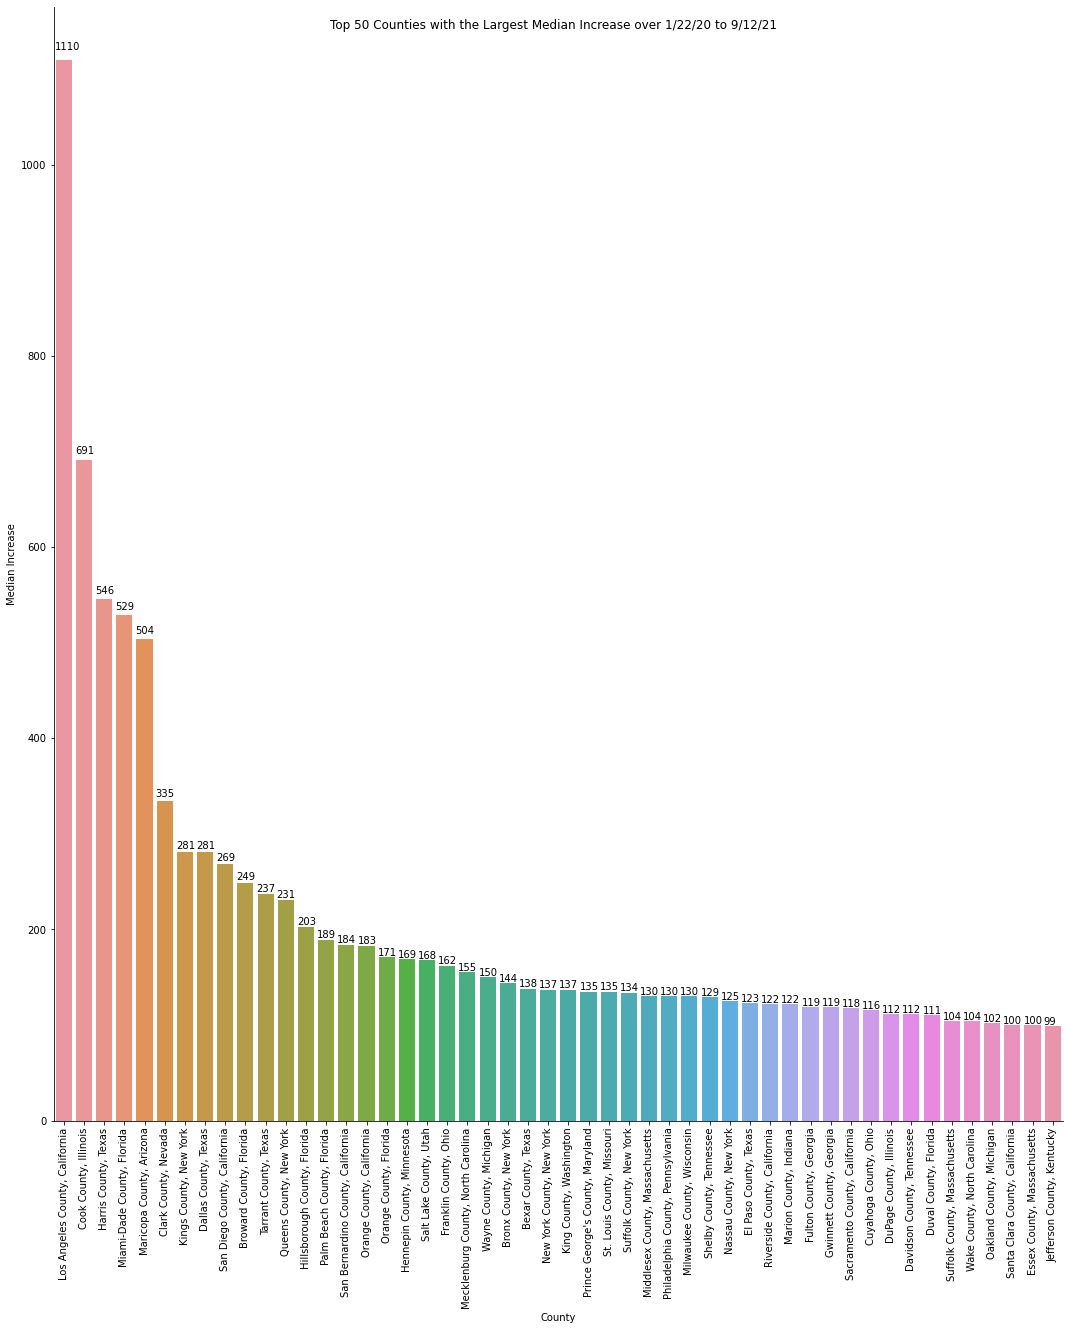

In [14]:
figure = sns.catplot(x="County", y="Median Increase", data=df_q2a, kind="bar", height=16, legend=True);
figure.set_xticklabels(rotation=90);
figure.fig.suptitle('Top 50 Counties with the Largest Median Increase over 1/22/20 to 9/12/21');
ax = figure.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.05, 
            p.get_height() * 1.01, 
            int(p.get_height()),  
            color='black', 
            rotation='horizontal', 
            size='medium');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2b

Create a visualization that shows the overall county-wise distribution of the number of COVID-19 cases per capita across the United States as a function of time. For all questions that reference population, use the population estimates from 2020.
<!--
BEGIN QUESTION
name: q2b
points: 4
manual: True
-->

In [15]:
df_q2b_by_county = county_data.copy()
df_q2b_by_county.loc[:,'1/22/20':'9/12/21'] = df_q2b_by_county.loc[:,'1/22/20':'9/12/21'].div(df_q2b_by_county["POPESTIMATE2020"], axis=0)
# df_q2b_by_county.head()

### By State

In this part we visualize the overall state-wise distribution of the number of COVID-19 cases per capita across the United States as a function of time. 

In [16]:
df_q2b_by_state = county_data.copy()
df_q2b_by_state = df_q2b_by_state.groupby("STNAME").agg(sum)
df_q2b_by_state.loc[:,'1/22/20':'9/12/21'] = df_q2b_by_state.loc[:,'1/22/20':'9/12/21'].div(df_q2b_by_state["POPESTIMATE2020"], axis=0)
# df_q2b_by_state.head()

In [17]:
df_q2b_by_state_plot = df_q2b_by_state.T
# df_q2b_by_state_plot.head()

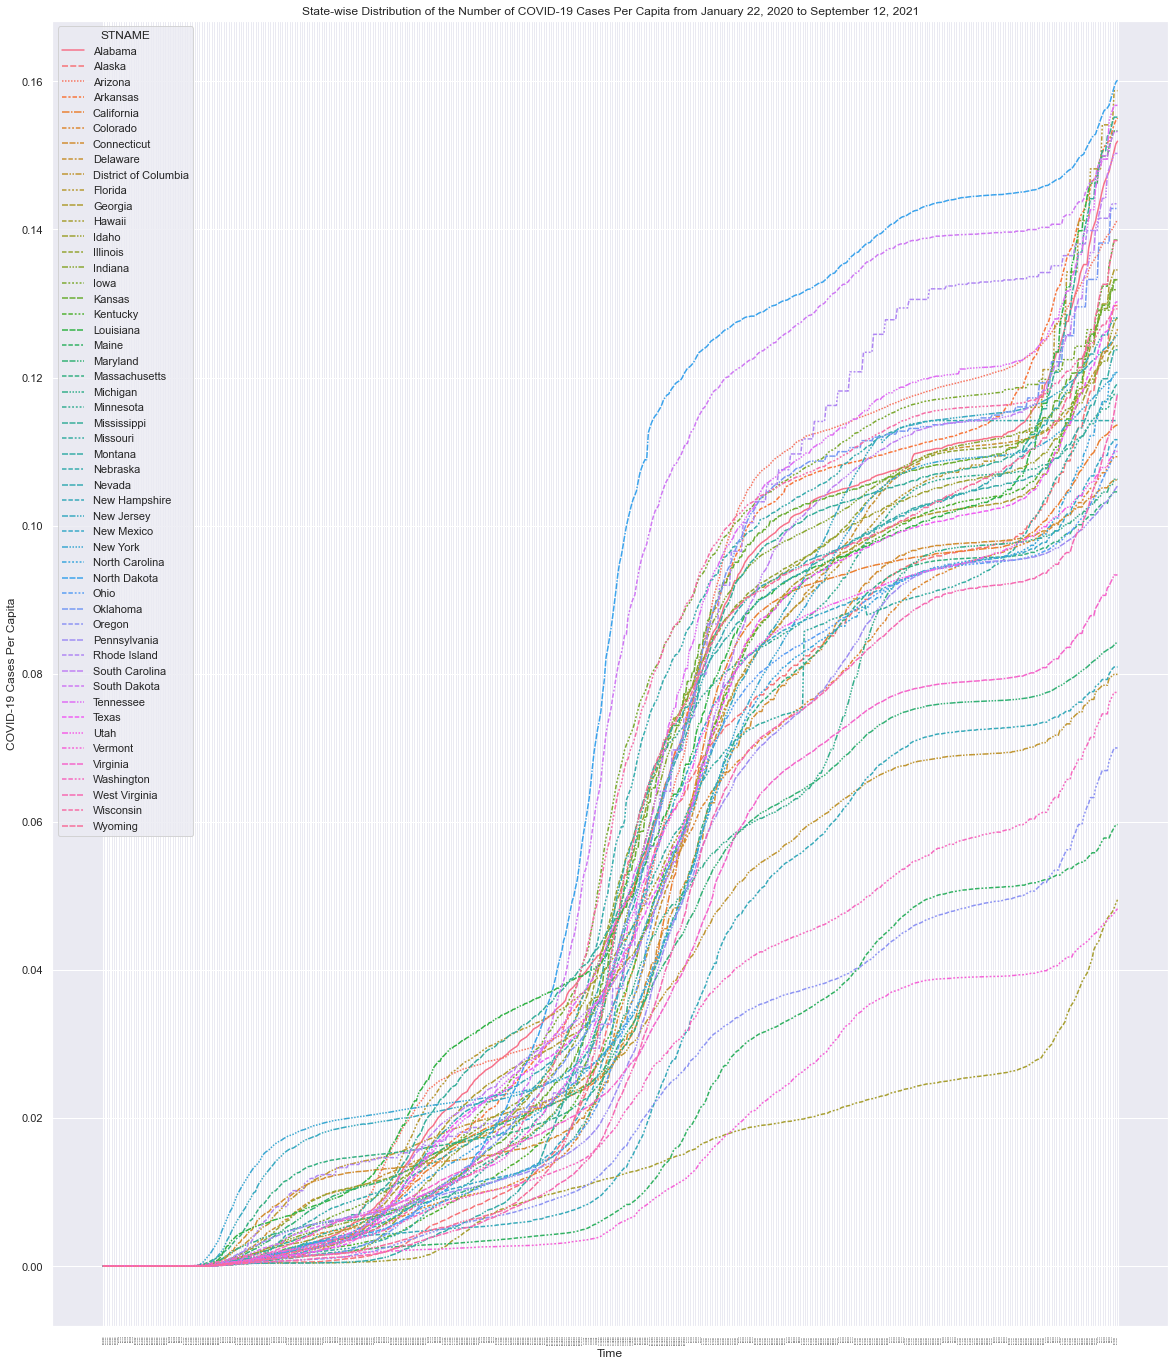

In [18]:
# We can change the time we want to investigate, now let's plot the data from January 22, 2020 to September 12, 2021
sns.set(rc={'figure.figsize':(20,24)});
figure = sns.lineplot(data=df_q2b_by_state_plot.loc['1/22/20':'9/12/21',:], legend=True);
plt.xticks(rotation=90);
plt.xticks(fontsize=2.5);
plt.xlabel("Time");
plt.ylabel("COVID-19 Cases Per Capita");
plt.title("State-wise Distribution of the Number of COVID-19 Cases Per Capita from January 22, 2020 to September 12, 2021");

### By County in Some Specific State (Example: Alaska)

In [19]:
df_q2b_by_county_ak = county_data.copy()
df_q2b_by_county_ak = df_q2b_by_county_ak[df_q2b_by_county_ak['STNAME'] == 'Alaska']
df_q2b_by_county_ak.loc[:,'1/22/20':'9/12/21'] = df_q2b_by_county_ak.loc[:,'1/22/20':'9/12/21'].div(df_q2b_by_county_ak["POPESTIMATE2020"], axis=0)
# df_q2b_by_county_ak.head()

In [20]:
df_q2b_by_county_ak.set_index("CTYNAME", inplace=True)
df_q2b_by_county_plot_ak = df_q2b_by_county_ak.T
# df_q2b_by_county_plot_ak.head()

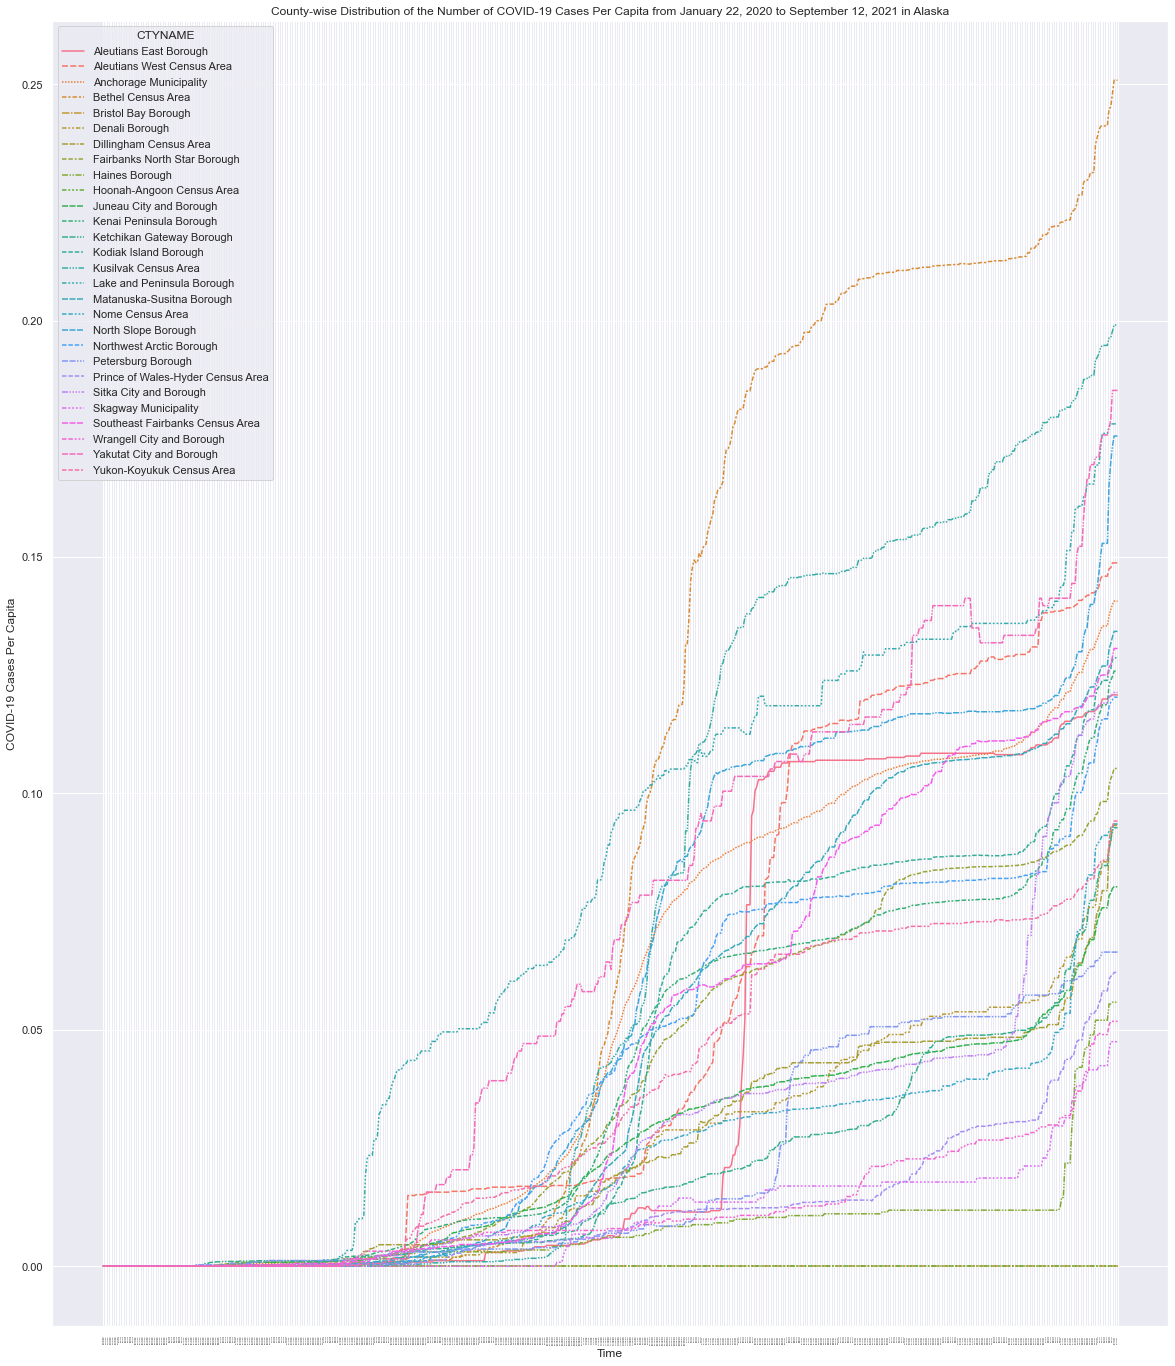

In [21]:
# We can change the time we want to investigate, now let's plot the data from January 22, 2020 to September 12, 2021
sns.set(rc={'figure.figsize':(20,24)});
figure = sns.lineplot(data=df_q2b_by_county_plot_ak.loc['1/22/20':'9/12/21',:].astype(float), legend=True);
plt.xticks(rotation=90);
plt.xticks(fontsize=2.5);
plt.xlabel("Time");
plt.ylabel("COVID-19 Cases Per Capita");
plt.title("County-wise Distribution of the Number of COVID-19 Cases Per Capita from January 22, 2020 to September 12, 2021 in Alaska");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2c

Create a visualization that shows states' increases in the number of COVID-19 cases per capita from September 3rd to September 12th, sorted from least to greatest increases. 

<!--
BEGIN QUESTION
name: q2c
points: 3
manual: True
-->

In [22]:
df_q2c_by_state = df_q2b_by_state.loc[:,'9/3/21':'9/12/21']
df_q2c_by_state['Increase in the Number of COVID-19 Cases Per Capita'] = df_q2b_by_state['9/12/21'] - df_q2b_by_state['9/3/21']
df_q2c_by_state.sort_values(by='Increase in the Number of COVID-19 Cases Per Capita', inplace=True)
df_q2c_by_state.reset_index(level=0, inplace=True)
df_q2c_by_state.rename(columns={'STNAME':'State'}, inplace=True)
# df_q2c_by_state.head()

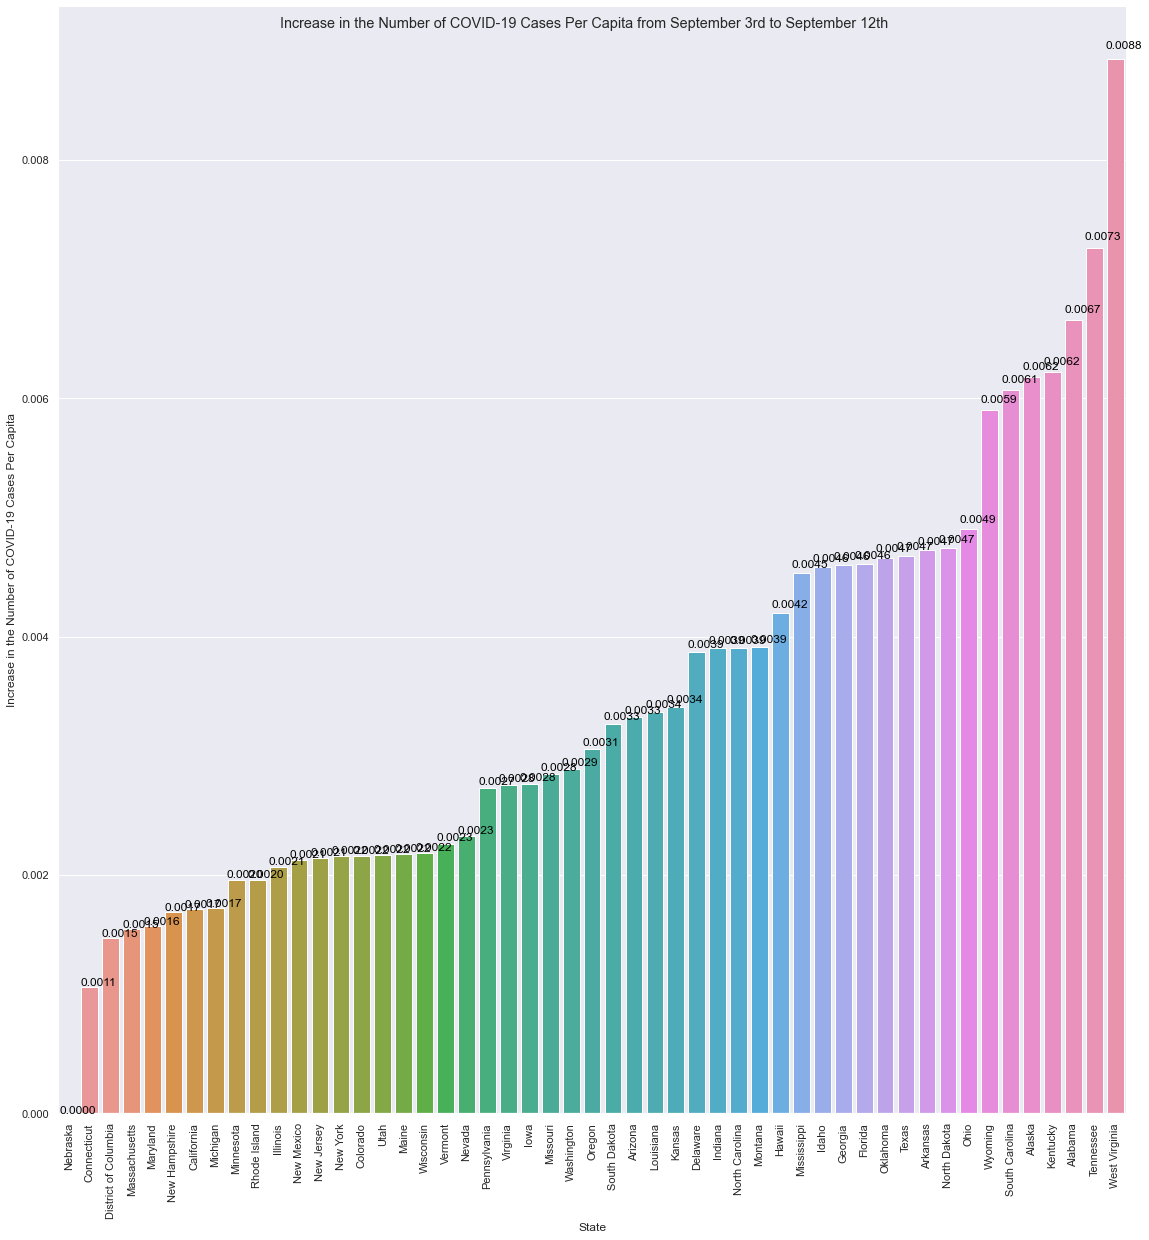

In [23]:
figure = sns.catplot(x="State", y="Increase in the Number of COVID-19 Cases Per Capita", data=df_q2c_by_state, kind="bar", height=16, legend=True);
figure.set_xticklabels(rotation=90);
figure.fig.suptitle('Increase in the Number of COVID-19 Cases Per Capita from September 3rd to September 12th');
ax = figure.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.05, 
            p.get_height() * 1.01, 
            "{:.4f}".format(float(p.get_height())),  
            color='black', 
            rotation='horizontal', 
            size='medium');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2d

Create a plot using a technique of your choice that visualizes the relationship between:

a) the number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

b) the frequency of never, rarely or sometimes wearing a mask in the respective counties

*Hint*: You may find a description of the data [here](https://github.com/CSSEGISandData/COVID-19/blob/846fa9458cc2a8904d2492d14d3e6b4f399ec027/csse_covid_19_data/csse_covid_19_time_series/README.md).

<!--
BEGIN QUESTION
name: q2d
points: 3
manual: True
-->

### Part A

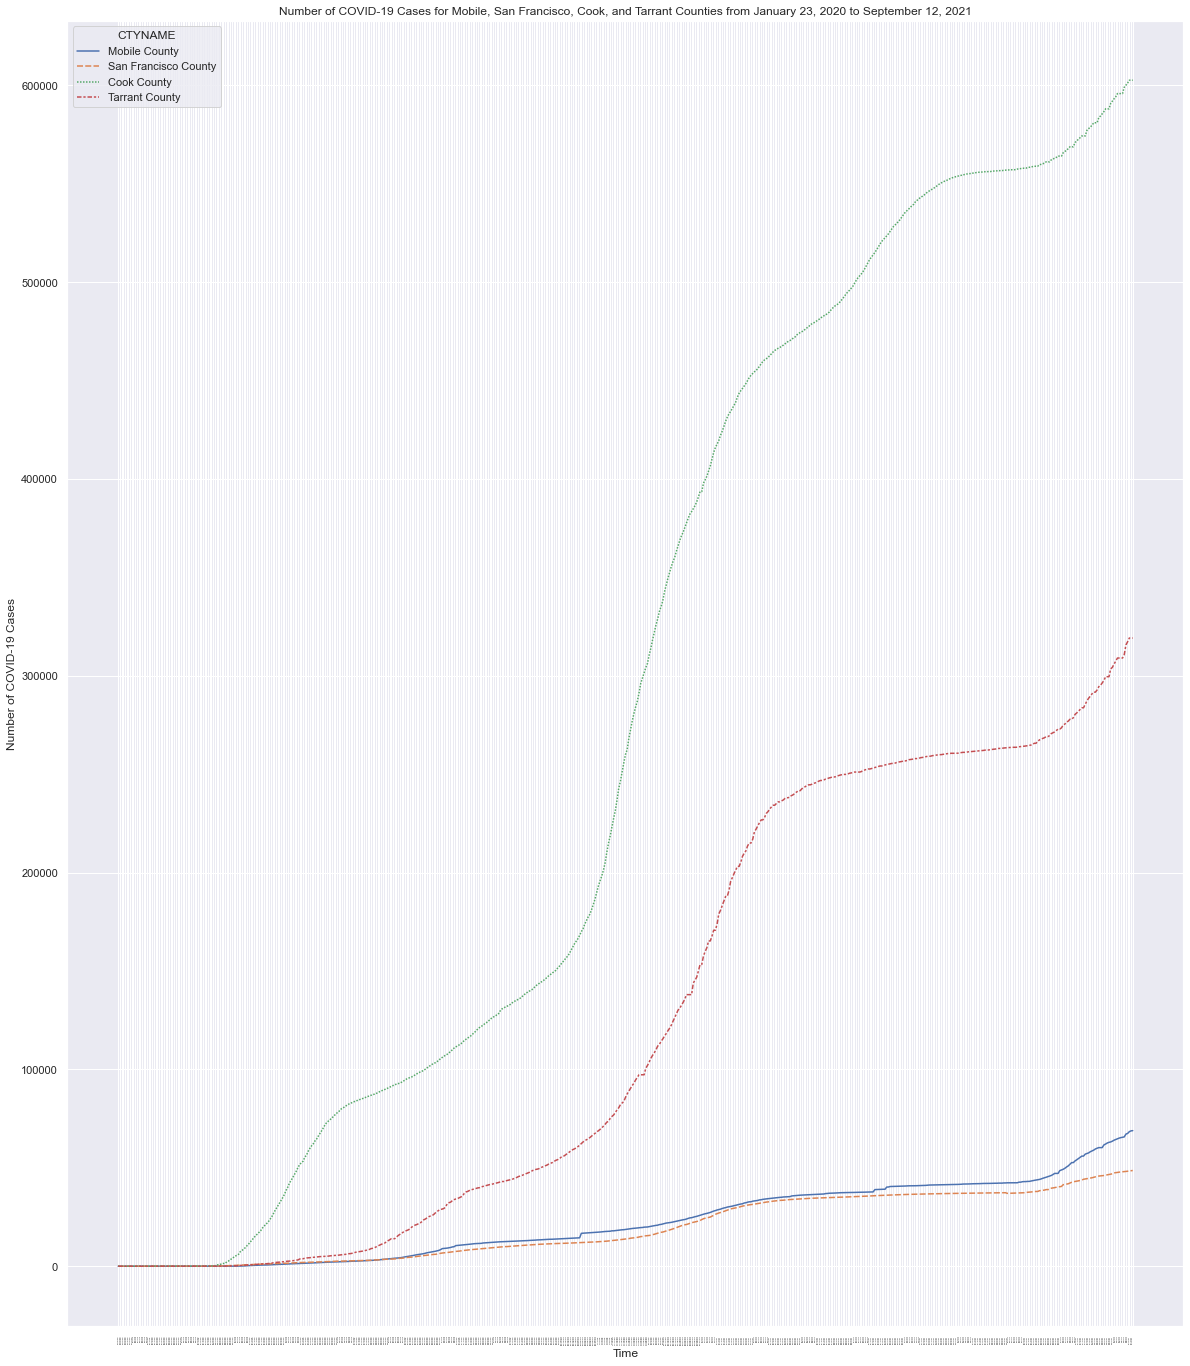

In [24]:
df_q2d = county_data.copy()
df_q2d = df_q2d[(df_q2d["CTYNAME"].isin(["Mobile County", "Tarrant County", "San Francisco County"]))|
      ((df_q2d["CTYNAME"] == "Cook County") & (df_q2d["STNAME"] == "Illinois"))]

df_q2d_a = df_q2d.set_index("CTYNAME").loc[:,'1/23/20':'9/12/21' ]
df_q2d_a_plot = df_q2d_a.T

sns.set(rc={'figure.figsize':(20,24)});
figure = sns.lineplot(data=df_q2d_a_plot, legend=True);
plt.xticks(rotation=90);
plt.xticks(fontsize=2.5);
plt.xlabel("Time");
plt.ylabel("Number of COVID-19 Cases");
plt.title("Number of COVID-19 Cases for Mobile, San Francisco, Cook, and Tarrant Counties from January 23, 2020 to September 12, 2021");

### Part B

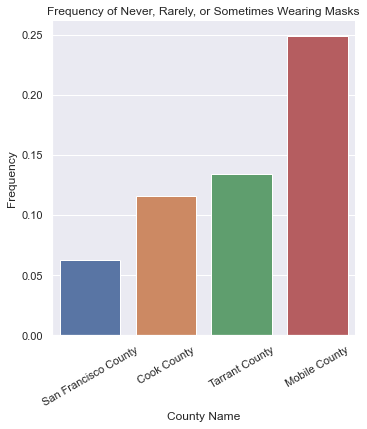

In [25]:
df_q2d["NEVER, RARELY OR SOMETIMES"] = df_q2d["NEVER"] + df_q2d["RARELY"] + df_q2d["SOMETIMES"]
df_q2d_b = df_q2d[["CTYNAME", "NEVER, RARELY OR SOMETIMES"]].sort_values("NEVER, RARELY OR SOMETIMES")

sns.set(rc={'figure.figsize':(8,6)})
figure = sns.catplot(x="CTYNAME", y="NEVER, RARELY OR SOMETIMES", data=df_q2d_b, 
                         kind="bar", legend=True)
plt.xlabel("County Name");
plt.ylabel("Frequency");
plt.title("Frequency of Never, Rarely, or Sometimes Wearing Masks");
plt.xticks(rotation=30);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e

Visualize and describe the spatial relationship between the location and the following quantities over the continguous United States:

a) the number of most recent COVID-19 cases per capita on September 12, 2021

b) the frequency of never, rarely or sometimes wearing a mask

*Hint*: Use `plotly` to generate a heatmap on a geographical plot of the United States!

<!--
BEGIN QUESTION
name: q2e
points: 5
manual: True
-->

### Part A

In [26]:
df_q2e = county_data.copy()
df_q2e = df_q2e.groupby("STNAME").sum()
df_q2e["9/12/21 per capita"] = df_q2e["9/12/21"]/df_q2e["POPESTIMATE2020"]
df_q2e = df_q2e[["9/12/21 per capita"]].rename(columns={"9/12/21 per capita":"Number of COVID-19 Cases Per Capita"}).reset_index()

In [27]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
replace_dict = {'STNAME': us_state_to_abbrev}
df_q2e.replace(replace_dict, inplace=True)

In [28]:
import plotly.express as px  
fig = px.choropleth(df_q2e,  # Input Pandas DataFrame
                    locations="STNAME",  # DataFrame column with locations
                    color="Number of COVID-19 Cases Per Capita",  # DataFrame column with color values
                    hover_name="Number of COVID-19 Cases Per Capita", # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Number of COVID-19 Cases Per Capita in the US on September 12, 2021',
    geo_scope='usa',
);
fig.show();

### Part B

In [29]:
df_q2e_b = county_data.copy()
df_q2e_b["NEVER, RARELY OR SOMETIMES"] = df_q2e_b["NEVER"] + df_q2e_b["RARELY"] + df_q2e_b["SOMETIMES"]
df_q2e_b = df_q2e_b.groupby("STNAME").mean().reset_index()[["STNAME", "NEVER, RARELY OR SOMETIMES"]].rename(columns={"NEVER, RARELY OR SOMETIMES":"Frequency"})
df_q2e_b.replace(replace_dict, inplace=True)

In [30]:
fig = px.choropleth(df_q2e_b,  # Input Pandas DataFrame
                    locations="STNAME",  # DataFrame column with locations
                    color="Frequency",  # DataFrame column with color values
                    hover_name="Frequency", # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Frequency of NEVER, RARELY or SOMETIMES Wearing Masks',
    geo_scope='usa',
);
fig.show();  

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2f

Describe and interpret the relationships in the plots above. What conclusions can be drawn about the COVID-19 dataset from these plots?

<!--
BEGIN QUESTION
name: q2f
points: 3
manual: True
-->

_The color distributions of the above two plots are very close. States with a large number of people who "NEVER, RARELY, or SOMETIMES" wear masks typically have more new COVID cases, while states where people always wear masks have fewer new COVID cases._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 3: Guided Unsupervised Exploration


<!-- BEGIN QUESTION -->

### Question 3a

Using SVD, decompose the standardized matrix $X$ that contains the standardized current proportion of fully vaccinated and partially vaccinated, cases per capita, and mask usage for every state as of the most recent day in the data.

*Hint*: The matrix $X$ should have rows that describe location.

<!--
BEGIN QUESTION
name: q3a
points: 3
manual: True
-->

In [31]:
temp = county_data.copy()[["Province_State", "9/12/21", "POPESTIMATE2020", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]]
X = pd.DataFrame(index=temp["Province_State"].unique())
vac_temp = vaccinations[vaccinations["Date"] == "2021-09-26"][["Province_State", "People_Fully_Vaccinated", "People_Partially_Vaccinated"]].set_index("Province_State")
X = X.merge(vac_temp, how="left", left_index=True, right_on="Province_State")
X["Cases_Per_Capita"] = temp[["Province_State", "9/12/21", "POPESTIMATE2020"]].groupby("Province_State").apply(lambda x: np.sum(x["9/12/21"])/np.sum(x["POPESTIMATE2020"]))
X[["Rarely", "Sometimes", "Frequently", "Always"]] = temp.groupby("Province_State")[["RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]].mean()
X = (X-X.mean())/X.std(axis=0)
u, s, vt = np.linalg.svd(X)
X

People_Fully_Vaccinated  People_Partially_Vaccinated  \
Province_State                                                               
Alabama                             -0.350270                    -0.078169   
Alaska                              -0.748397                    -0.609991   
Arizona                              0.033181                     0.036478   
Arkansas                            -0.514966                    -0.306495   
California                           4.739031                     5.278886   
Colorado                            -0.026522                    -0.246737   
Connecticut                         -0.263022                    -0.359293   
Delaware                            -0.704979                    -0.571225   
District of Columbia                -0.713000                    -0.583065   
Florida                              2.032183                     1.813037   
Georgia                              0.287360                     0.531311   
Hawaii                              -0.611711                    -0.354708   
Idaho                               -0.653604                    -0.557093   
Illinois                             0.804061                     1.562416   
Indiana                             -0.073615                    -0.369760   
Iowa                                -0.438104                    -0.516368   
Kansas                              -0.488278                    -0.371106   
Kentucky                            -0.290535                    -0.227807   
Louisiana                           -0.343338                    -0.319067   
Maine                               -0.620769                    -0.582004   
Maryland                             0.074137                    -0.205245   
Massachusetts                        0.259647                     0.100019   
Michigan                             0.386266                    -0.119004   
Minnesota                           -0.068523                    -0.311296   
Mississippi                         -0.531189                    -0.431778   
Missouri                            -0.149908                    -0.162655   
Montana                             -0.714911                    -0.591934   
Nebraska                            -0.589128                    -0.561104   
Nevada                              -0.470826                    -0.307721   
New Hampshire                       -0.640206                    -0.545176   
New Jersey                           0.530749                     0.186177   
New Mexico                          -0.526601                    -0.437809   
New York                             2.058520                     1.057951   
North Carolina                       0.458014                     0.524590   
North Dakota                        -0.757035                    -0.609031   
Ohio                                 0.536735                    -0.115681   
Oklahoma                            -0.396871                    -0.250258   
Oregon                              -0.238210                    -0.376569   
Pennsylvania                         0.894497                     1.521010   
Rhode Island                        -0.654007                    -0.583500   
South Carolina                      -0.269446                    -0.180881   
South Dakota                        -0.729243                    -0.593972   
Tennessee                           -0.104025                    -0.071304   
Texas                                2.633780                     2.311294   
Utah                                -0.443978                    -0.350979   
Vermont                             -0.730875                    -0.610410   
Virginia                             0.371325                     0.123698   
Washington                           0.243893                    -0.087870   
West Virginia                       -0.639668                    -0.507576   
Wisconsin                           -0.06758

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b

Visualize the top 2 principal components and label the data points with the corresponding location. Color each data points based on the number of cases per capita in the location to which it corresponds.

<!--
BEGIN QUESTION
name: q3b
points: 3
manual: True
-->

In [32]:
pc2 = (X @ vt.T).iloc[:, :2].reset_index()
pc2.columns = ["State", "P1", "P2"]
pc2 = pc2.merge(X["Cases_Per_Capita"], how="left", left_on = "State", right_index=True)
fig = px.scatter(pc2, x='P1', y='P2', text="State", color="Cases_Per_Capita", 
                 title="Relationship Between the First and Second Principal Components", 
                 labels={
                     "P1": "pc1",
                     "P2": "pc2",
                     "Cases_Per_Capita": "Cases Per Capita (Normalized)"
                 }, width=1100, height=700);
fig.show();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3c

What could the first and second principal component roughly represent? Interpret the visualization above and report any findings from the first two principal components given by PCA.

<!--
BEGIN QUESTION
name: q3c
points: 3
manual: True
-->

_The first principal component roughly represnets how frequent people wear masks. The more frequent people wear masks, the higher pc1 value does the state get. The second principal comonent roughly represents the percentage of fully or partially vaccined individuals in the state. The higher the percentage of fully or partially vaccinated inidividuals, the lower the pc2 value does the state get._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3d

Construct a scree plot displaying the proportion of variance captured by each principal component.

<!--
BEGIN QUESTION
name: q3d
points: 3
manual: True
-->

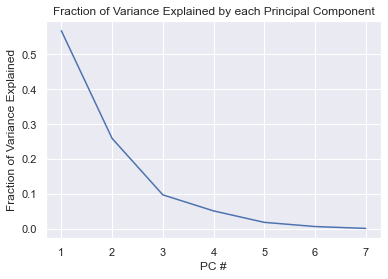

In [33]:
%matplotlib inline
prop = s**2/np.sum(s**2)
plt.plot(range(1, len(s)+1), prop)
plt.xlabel('PC #')
plt.ylabel('Fraction of Variance Explained')
plt.title('Fraction of Variance Explained by each Principal Component');

<!-- END QUESTION -->

### Question 3e

Using the 2D representation of each state's first two principal components $x_i = [\text{PC}_1, \text{PC}_2]$, find each state's 5 closest principal component neighbors using Euclidean distance as the metric. In other words, for each state $i$ with first two principal components $x_i$, the following would be its *closest* principal component neighbor:

$$
\arg \min_{j \ne i} ||x_j - x_i||_2
$$

Store each state's 5 closest neighbors in a Pandas DataFrame, where the index is the state's name and the columns are the 5 closest PC neighbors.

<!--
BEGIN QUESTION
name: q3e
points: 3
-->

In [34]:
pc2_copy = pc2.set_index("State")[["P1", "P2"]]
state_mins = pd.DataFrame(index=pc2_copy.index, columns=["1st", "2nd", "3rd", "4th", "5th"])
for i in pc2_copy.index:
    temp = pd.DataFrame(columns=["state", "dist"])
    temp.set_index("state")
    for j in pc2_copy.index:
        if i != j:
            temp.loc[j,:] = np.linalg.norm(pc2_copy.loc[j,:]-pc2_copy.loc[i,:], ord=2)
    state_mins.loc[i,:] = temp.sort_values("dist", ascending=True).head(5).index
# state_mins.head(10)

In [35]:
grader.check("q3e")

q3e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 3f

Investigate the principal component neighbors for two states of your choice, and remark on any observations you have about their COVID-19 statistics given in the dataset, geographical or political ties. 

Compare these neighbors with the rankings from the visualization from Question 2c that depicted recent greatest increases in cases across states.

<!--
BEGIN QUESTION
name: q3f
points: 3
manual: True
-->

_California: the principal component neighbors are Texas, Florida, New York, Pennsylvania, and Illinois. These are all states that have large number of COVID cases, and are the states that have more dense population._ 

_Alabama: the principal component neighbors are Indiana, Ohio, Arkansas, Wisconsin, and Tennessee. These states are all located in the middle part of the U.S., and are more of the rural areas where the population is less dense, where COVID cases are more sparse in these states._

_Compared with the visualization from Question 2c, we can conclude that those states who are neighbors of Alabama are more likely to have larger COVID cases per capita, because people in these states are more unwilling to wear masks frequently._

<!-- END QUESTION -->

### Question 3g

We will investigate the relationship between geographical distance in miles and top two principal component distance between any two unique pairs of states. 

For the sake of simplicity, may assume that the singular geographical location of a state is given by the mean latitude and longitude of all the counties in that state. For each unique pair of states, calculate the geographical distance and the Euclidean distance between their top 2 principal components between them. Plot the relationship where the x-axis represents the top 2 principal component distance and the y-axis represents geographical distance.

*Hint*: `geopy` has a function that can calculate distance between two pairs of latitude and longitude!

*Hint*: You should be plotting 1,275 points.

<!--
BEGIN QUESTION
name: q3g
points: 3
-->

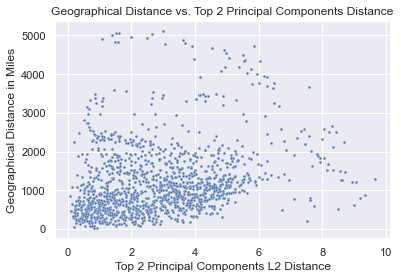

In [36]:
from geopy import distance
x, y = [], []
for i in range(len(pc2_copy.index)):
    for j in range(i+1, len(pc2_copy.index)):
        x.append(np.linalg.norm(pc2_copy.iloc[j,:]-pc2_copy.iloc[i,:], ord=2))

geo = vaccinations[["Province_State", "Lat", "Long_"]].groupby("Province_State").first()
geo = geo[geo.index.isin(pc2_copy.index)]
for i in range(len(geo.index)):
    for j in range(i+1, len(geo.index)):
        y.append(distance.distance(geo.iloc[i,:], geo.iloc[j,:]).miles)

sns.scatterplot(x, y, s=8);
plt.title("Geographical Distance vs. Top 2 Principal Components Distance");
plt.xlabel("Top 2 Principal Components L2 Distance");
plt.ylabel("Geographical Distance in Miles");

### Question 3h

Interpret the relationship displayed in part (g). What does this suggest about the role that geography plays within this dataset despite no geographical information explicitly encoded within the matrix  $X$ from part (a)?

<!--
BEGIN QUESTION
name: q3h
points: 3
-->

_The visualization in part (g) shows that there is a positive relationship between PC distance and geographical distance. As the top 2 principal components distance increases, the geographical distance also tends to increase. This suggests that geography is an underlying influence on the number of COVID cases in each state. However, the influence of geography distance is not very strong, as the data points in the scatter plot are rather spread out, despite having an overall proportional trend._

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

<br/><br/><br/>

## Question 4: Open EDA

Perform EDA of your choice on the data to generate 2 visualizations. You may follow the line of investigation in the guided sections by visualizing the relationship between safety protocols and the spread of COVID-19 spatially or temporally, or you may explore other areas of your choice. 

For each visualization, make sure to address the following:

1. Address a relationship in the data concerning the spread, effect, or prevention of COVID-19 through a visualization, with at *most* one univariate data visualization. If needed, use an unsupervised learning technique such as PCA to reveal patterns within the data.
2. Comment on the visualization in terms of the distribution, trends, and patterns it shows.
3. Comment on what the visualization indicates about the data with regards to the features you may choose for a supervised learning task.

<!--
BEGIN QUESTION
name: q4
points: 30
manual: True
-->

## (1) Cases and Vaccination in California

In [37]:
cases_masks = county_data.copy()
California_cases = cases_masks[cases_masks["STNAME"] == "California"].groupby("STNAME").mean().loc[:,'1/23/20':'9/12/21' ]
Cal_cases = California_cases.T.reset_index().rename(columns={"index":"Date", "California":"Number of Cases"})
Cal_cases['Date'] = pd.to_datetime(Cal_cases.Date)
Cal_cases["Date"] = np.datetime_as_string(Cal_cases["Date"], unit='D')
Cal_vaccinations = vaccinations[vaccinations["Province_State"] == "California"][["Date", "People_Fully_Vaccinated", "People_Partially_Vaccinated"]]
Cal_capital = cases_masks.groupby("STNAME").sum()["POPESTIMATE2020"]["California"]
Cal_cases_vacin = pd.merge(Cal_cases, Cal_vaccinations, how="inner", on="Date")
Cal_cases_vacin["Cases Per Capita (100 times)"] = Cal_cases_vacin["Number of Cases"]/Cal_capital * 100
Cal_cases_vacin["Fully Vaccinated Per Capita"] = Cal_cases_vacin["People_Fully_Vaccinated"]/Cal_capital
Cal_cases_vacin["Partially Vaccinated Per Capita"] = Cal_cases_vacin["People_Partially_Vaccinated"]/Cal_capital
Cal_cases_vacin = Cal_cases_vacin.set_index("Date")

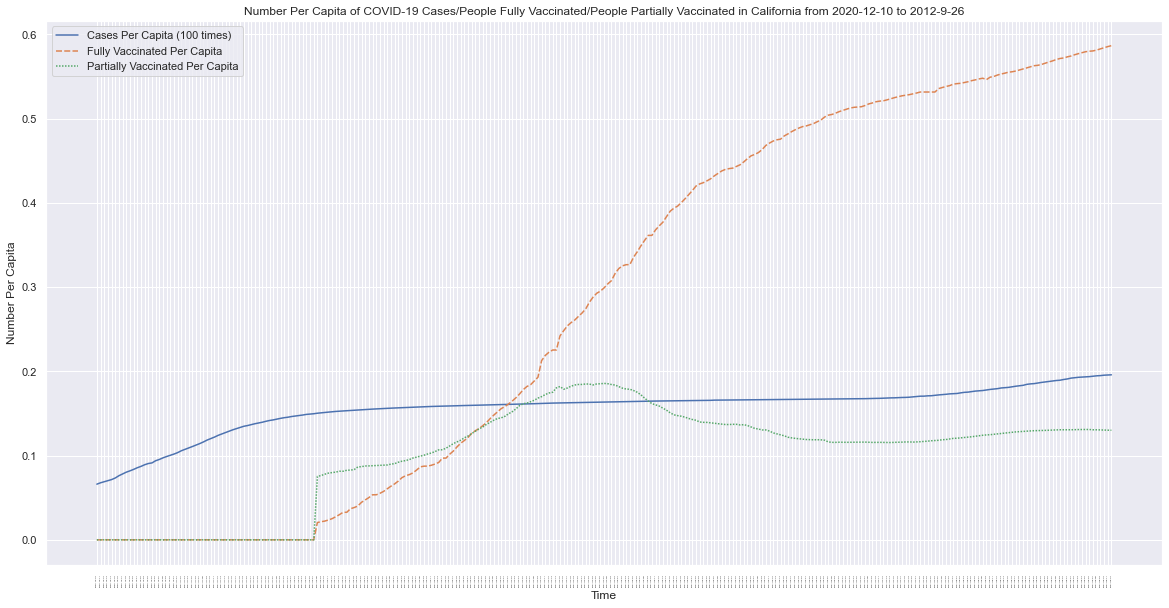

In [39]:
df_q4_plot = Cal_cases_vacin[["Cases Per Capita (100 times)", "Fully Vaccinated Per Capita", "Partially Vaccinated Per Capita"]]
sns.set(rc={'figure.figsize':(20,10)});
figure = sns.lineplot(data=df_q4_plot, legend=True);
plt.xticks(rotation=90);
plt.xticks(fontsize=2.5);
plt.xlabel("Time");
plt.ylabel("Number Per Capita");
plt.title("""Number Per Capita of COVID-19 Cases/People Fully Vaccinated/People Partially Vaccinated in California from 2020-12-10 to 2012-9-26""");

### Explanation 
The plot above shows the total number of new COVID-19 cases and total number of people that are fully/partially vaccinated in California from 2020-12-10 to 2012-9-26.

From the above plot, before the COVID vaccines were put into use, the number of new COVID cases in California increased rapidly every day. However, after the start of mass vaccination, the growth rate slowed down significantly, and the number of new infections remained almost unchanged for nearly one year. Although there were many other factors that influenced the situation, from the above plot we can conclude that vaccination has positive effect on preventing the spread of COVID-19.

## (2) Mean Increase and Mask Use in California

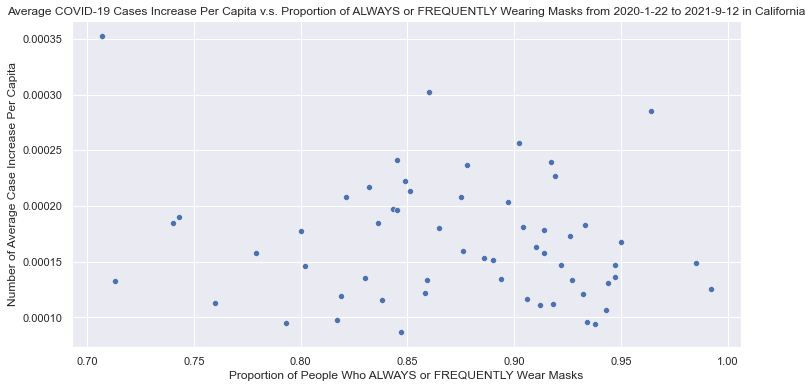

In [40]:
Cal_cases_masks = cases_masks[cases_masks["STNAME"] == "California"]
Cal_cases_masks['mean_increase per capital'] = Cal_cases_masks.loc[:,'1/22/20':'9/12/21'].diff(axis=1).mean(axis=1)/Cal_cases_masks['POPESTIMATE2020']
x = Cal_cases_masks["ALWAYS"] + Cal_cases_masks["FREQUENTLY"]
y = Cal_cases_masks['mean_increase per capital']
sns.set(rc={'figure.figsize':(12,6)});
sns.scatterplot(x, y);
plt.title("""Average COVID-19 Cases Increase Per Capita v.s. Proportion of ALWAYS or FREQUENTLY Wearing Masks from 2020-1-22 to 2021-9-12 in California""");
plt.xlabel("Proportion of People Who ALWAYS or FREQUENTLY Wear Masks");
plt.ylabel("""Number of Average Case Increase Per Capita""");

### Explanation 
The plot above shows the relationship between the proportion of people who reported to "ALWAYS" or "FREQUENTLY" wear a mask and the number of mean COVID-19 cases increase per capita from 2020-1-22 to 2021-9-12 in California, where each point in the plot represents one county.

There's no clear relationship between the two variables in the plot: there are counties where people do not always wearing a mask but have low mean increase, and there are counties where over 90% of people always wearing a mask but have relatively high mean increase.

It seems that wearing a mask is not the only factor that influences the increase of COVID cases. In addition, we notice that, among those who reported to always/frequently wear a mask, they may not wear the mask properly and they may also lie about the fact.


---

To double-check your work, the cell below will rerun all of the autograder tests.

In [41]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q3e results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()